<a href="https://colab.research.google.com/github/pasquale90/mthesis/blob/master/code/initialcode/5-stfts_esc50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Google_drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Import libraries
import os
import pandas as pd
import librosa
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

data_path='/content/gdrive/My Drive/dissertation/ESC-50-master/meta/'
audio_path='/content/gdrive/My Drive/dissertation/ESC-50-master/audio/'
featurepath='/content/gdrive/My Drive/dissertation/ESC-50-master/features/stfts/exp4/'
#featurepath='/content/gdrive/My Drive/dissertation/ESC-50-master/features/stfts/exp8/'

In [ ]:
'''
print(len(os.listdir(featurepath)))
for afn in  os.listdir(featurepath):
  name=afn.split('_')[0]+'.png'
  #print(name)
  os.rename(featurepath+afn,featurepath+name)
'''

In [3]:
#Import Dataset
esc50 = pd.read_csv(data_path+'esc50.csv')
audiofiles = os.listdir(audio_path)
print(esc50.shape)
print(len(audiofiles))

(2000, 7)
2000


In [4]:
#train and fold definition
#make this 5-fold
train = esc50[esc50['fold']!=5]
valid = esc50[esc50['fold']==5]

In [5]:
def get_features(wavname):
  name=featurepath+wavname.split('.')[0]+'.png'
  image=Image.open(name)
  image=np.array(image)
  image = image/255.0 #normalize images
  return image

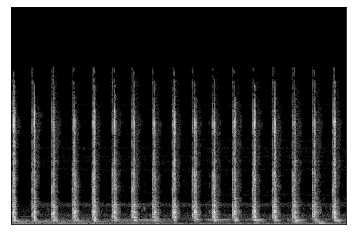

In [10]:
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
librosa.display.specshow(get_features(filename), cmap='gray')

In [6]:
class ESC50Data(Dataset):
  def __init__(self, df, in_col, out_col):#(train, 'filename', 'category')
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      stfts=get_features(row['filename'])
      self.data.append(stfts[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [30]:
#exp4 model 1       (greater stride in layers)
class ESC50Model1(nn.Module):
  def __init__(self, input_shape, num_cats=50):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(4096,500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = F.max_pool2d(x, kernel_size=2) #pool
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) #pool
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = F.max_pool2d(x, kernel_size=2) #pool
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [11]:
#exp 8 model 2
class ESC50Model2(nn.Module):
  def __init__(self, input_shape, num_cats=50):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [27]:
#model 3
class ESC50Model3(nn.Module):
  def __init__(self, input_shape, num_cats=50):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, stride=1, padding=1 )
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(256)
    self.conv7 = nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(512)
    self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
    self.bn8 = nn.BatchNorm2d(512)
    self.dense1 = nn.Linear(2048,512)
    #self.dense1 = nn.Linear(512*((((input_shape[1]//2)//2)//2)//2)*((((input_shape[2]//2)//2)//2)//2),750)
    self.dropout = nn.Dropout(0.25)
    self.dense2 = nn.Linear(512, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [8]:
#load stfts
train_data = ESC50Data(train, 'filename', 'category' )
valid_data = ESC50Data(valid, 'filename', 'category')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [9]:
#exp4 #exp8 -->model 1,2
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [10]:
#exp 4 - model 3
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True)

In [ ]:
'''
To retrieve a sample mini-batch, one can simply run the command below 
it will return a list containing two tensors, 
one for the features, 
another one for the labels.

next(iter(train_loader))


if you have many GPUs to train your model on, it is best to keep your dataset “agnostic” and assign the batches to different GPUs during training.
'''

In [11]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
print(device)

cpu


In [28]:
#model = ESC50Model1(input_shape=(1,431,513), num_cats=50).to(device)
#model = ESC50Model2(input_shape=(1,257, 431), num_cats=50).to(device)
model = ESC50Model3(input_shape=(1,431,513), num_cats=50).to(device) #small batch size due to vast increase in colab's ram

In [29]:
#optimizer?
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [30]:
#CREATE AURPC METRICS
#https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265
#https://github.com/allenai/allennlp/issues/1863
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#model.parameters()is a method 
                                                            #to retrieve an iterator over all model’s parameters
epochs = 10
train_losses = []
valid_losses = []

In [31]:
def train(model, loss_fn, train_loader, valid_loader,
          epochs, optimizer, train_losses, valid_losses, change_lr):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()#set the model to training mode
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in tqdm(enumerate(train_loader)):#performs a step in the train loop 
      x, y = data
      optimizer.zero_grad()#zero the gradients before updating them
      x = x.to(device, dtype=torch.float32) #init tensor _minibatch(16) of spectograms
      y = y.to(device, dtype=torch.long)  #init tensor _categories' id
      y_hat = model(x) #the equation is the model itself-,model is actually a modeled equation
      loss = loss_fn(y_hat, y)#loss = loss_fn(y_train_tensor, yhat)
      loss.backward() #for alleviating the parameters' loss
      batch_losses.append(loss.item()) #here batch_calc is returned
      #print('batch_losses=={}'.format(len(batch_losses)))
      optimizer.step()#step of the optimizer-updates the parameters/  batch?mini-batch?stohastic? 
    train_losses.append(batch_losses)

    print()
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    print()
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)#mean of Trues

  
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy} ')

In [32]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

In [35]:
#exp4  imsize=(431,513) model 1
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Epoch - 1 Train-Loss : 3.8510108852386473

Epoch - 1 Valid-Loss : 3.726043157577515 Valid-Accuracy : 0.1025 




Epoch - 2 Train-Loss : 3.622592487335205

Epoch - 2 Valid-Loss : 3.549949836730957 Valid-Accuracy : 0.125 




Epoch - 3 Train-Loss : 3.4082305455207824

Epoch - 3 Valid-Loss : 3.3708298873901366 Valid-Accuracy : 0.16 




Epoch - 4 Train-Loss : 3.205129771232605

Epoch - 4 Valid-Loss : 3.215430564880371 Valid-Accuracy : 0.1875 




Epoch - 5 Train-Loss : 3.0307847690582275

Epoch - 5 Valid-Loss : 3.0908931255340577 Valid-Accuracy : 0.24 




Epoch - 6 Train-Loss : 2.8284497237205506

Epoch - 6 Valid-Loss : 2.955162696838379 Valid-Accuracy : 0.265 




Epoch - 7 Train-Loss : 2.6803009581565855

Epoch - 7 Valid-Loss : 2.850283451080322 Valid-Accuracy : 0.3125 




Epoch - 8 Train-Loss : 2.501489505767822

Epoch - 8 Valid-Loss : 2.744833574295044 Valid-Accuracy : 0.325 




Epoch - 9 Train-Loss : 2.333587038516998

Epoch - 9 Valid-Loss : 2.6415066051483156 Valid-Accuracy : 0.3475 




Epoch - 10 Train-Loss : 2.2056017327308655

Epoch - 10 Valid-Loss : 2.5263447380065918 Valid-Accuracy : 0.375 



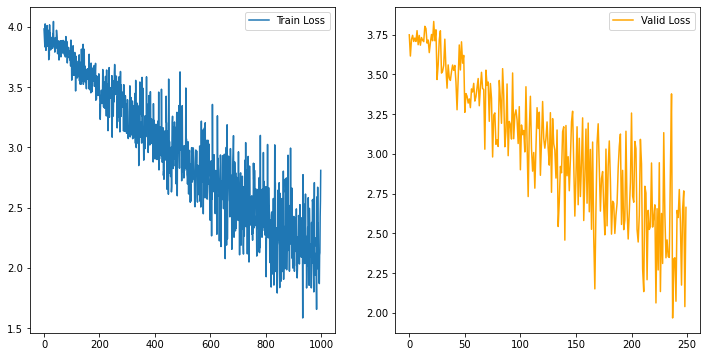

In [36]:
#exp4
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
#exp8  imsize=(257, 431) model 2
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Epoch - 1 Train-Loss : 3.9674181270599367

Epoch - 1 Valid-Loss : 3.527582912445068 Valid-Accuracy : 0.1075 




Epoch - 2 Train-Loss : 3.3521688199043274

Epoch - 2 Valid-Loss : 3.23701642036438 Valid-Accuracy : 0.205 




Epoch - 3 Train-Loss : 2.9151821160316467

Epoch - 3 Valid-Loss : 3.021325206756592 Valid-Accuracy : 0.245 




Epoch - 4 Train-Loss : 2.3479837775230408

Epoch - 4 Valid-Loss : 2.757779483795166 Valid-Accuracy : 0.2875 




Epoch - 5 Train-Loss : 1.8255080080032349

Epoch - 5 Valid-Loss : 2.621629796028137 Valid-Accuracy : 0.34 




Epoch - 6 Train-Loss : 1.3934749090671539

Epoch - 6 Valid-Loss : 2.5037493181228636 Valid-Accuracy : 0.3625 




Epoch - 7 Train-Loss : 1.091808098256588

Epoch - 7 Valid-Loss : 2.510100202560425 Valid-Accuracy : 0.37 




Epoch - 8 Train-Loss : 0.8060617908835411

Epoch - 8 Valid-Loss : 2.3946729707717895 Valid-Accuracy : 0.395 




Epoch - 9 Train-Loss : 0.658097160756588

Epoch - 9 Valid-Loss : 2.3400408601760865 Valid-Accuracy : 0.4075 




Epoch - 10 Train-Loss : 0.45509694203734397

Epoch - 10 Valid-Loss : 2.3069335508346556 Valid-Accuracy : 0.425 



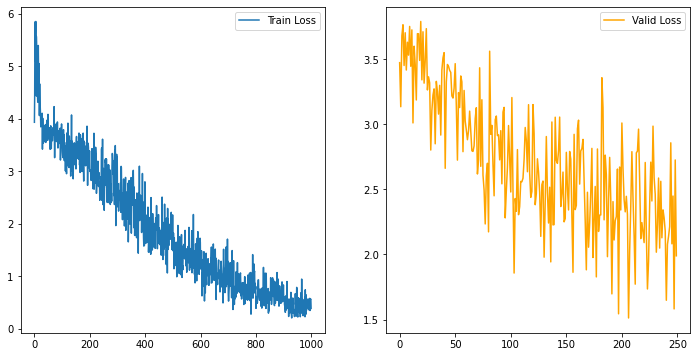

In [ ]:
#exp8
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
#exp4  imsize=(431,513) model 3 -- interrupted
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Epoch - 1 Train-Loss : 3.773648234009743

Epoch - 1 Valid-Loss : 3.564129214286804 Valid-Accuracy : 0.1275 




Epoch - 2 Train-Loss : 3.364934973716736

Epoch - 2 Valid-Loss : 3.223699493408203 Valid-Accuracy : 0.1725 




Epoch - 3 Train-Loss : 3.0062428551912306

Epoch - 3 Valid-Loss : 2.9533516788482665 Valid-Accuracy : 0.255 




Epoch - 4 Train-Loss : 2.6377466407418253

Epoch - 4 Valid-Loss : 2.7422818660736086 Valid-Accuracy : 0.31 




Epoch - 5 Train-Loss : 2.27708961725235

Epoch - 5 Valid-Loss : 2.505933949947357 Valid-Accuracy : 0.375 




Epoch - 6 Train-Loss : 1.9241415730118752

Epoch - 6 Valid-Loss : 2.2906141412258147 Valid-Accuracy : 0.41 




Epoch - 7 Train-Loss : 1.5442272174358367

Epoch - 7 Valid-Loss : 2.1999534714221953 Valid-Accuracy : 0.46 




Epoch - 8 Train-Loss : 1.216801691055298

Epoch - 8 Valid-Loss : 2.139817004799843 Valid-Accuracy : 0.4925 




Epoch - 9 Train-Loss : 0.9086612414568662



In [ ]:
    Count of the class in the ground truth target data;
    Count of the class in the predictions;
    Count how many times the class was correctly predicted.

Let's assume you want to compute F1 score for the class with index 0 in your softmax. In every batch, you can do:

predicted_classes = torch.argmax(y_pred, dim=1) == 0
target_classes = self.get_vector(y_batch)
target_true += torch.sum(target_classes == 0).float()
predicted_true += torch.sum(predicted_classes).float()
correct_true += torch.sum(
    predicted_classes == target_classes * predicted_classes == 0).float()

In [ ]:
with open('stfts2model.pth','wb') as f:
  torch.save(model, f)

In [ ]:
import pickle
with open('stfts2data.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)